In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras_cv

Using TensorFlow backend


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization,GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score,accuracy_score
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras import regularizers
import os
import sklearn.metrics
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import keras as ks
from sklearn.preprocessing import MinMaxScaler
from keras import layers
from tensorflow.keras.models import Model

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/merged_data.csv', index_col='ts', parse_dates=True)

In [ ]:
dataset

,event_rssi,event_rsrp,event_rsrq,rtt,event_band,event_lte_freq,anomaly_label,node_id_4135,node_id_4137,node_id_4147
ts,,,,,,,,,,
2023-11-01 00:00:00,-39.0,-62.0,-8.0,0.044847,20.0,800.0,0,0,1,0
2023-11-01 00:00:00,-45.0,-68.0,-7.0,0.057562,8.0,900.0,1,1,0,0
2023-11-01 00:00:00,-51.0,-81.0,-10.0,0.019667,20.0,800.0,0,0,0,1
2023-11-01 00:00:01,-51.0,-81.0,-10.0,0.011093,20.0,800.0,0,0,0,1
2023-11-01 00:00:01,-39.0,-62.0,-8.0,0.052272,20.0,800.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2023-11-14 23:59:58,-55.0,-81.0,-10.0,0.046952,20.0,800.0,1,0,0,1
2023-11-14 23:59:58,-46.0,-69.0,-8.0,0.056164,8.0,900.0,1,1,0,0
2023-11-14 23:59:59,-46.0,-70.0,-8.0,0.036725,8.0,900.0,0,0,1,0


In [ ]:
dataset_try = dataset.drop(columns=['event_rsrp','event_device_state','event_rssi','event_band','event_lte_freq','event_rsrq'])

In [ ]:
data = dataset[['rtt','anomaly_label', 'node_id_4147','node_id_4135','node_id_4137']]

In [ ]:
window_size = 10  # Adjust as needed
data['rtt_mean'] = data['rtt'].rolling(window=window_size).mean()
data['rtt_std'] = data['rtt'].rolling(window=window_size).std()
data['rtt_max'] = data['rtt'].rolling(window=window_size).max()
data['rtt_min'] = data['rtt'].rolling(window=window_size).min()

<ipython-input-6-487ea060f9f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rtt_mean'] = data['rtt'].rolling(window=window_size).mean()
<ipython-input-6-487ea060f9f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rtt_std'] = data['rtt'].rolling(window=window_size).std()
<ipython-input-6-487ea060f9f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [ ]:
dataset['hour'] = dataset.index.hour
dataset['day_of_week'] = dataset.index.dayofweek
dataset['is_weekend'] = dataset.index.dayofweek.isin([5, 6]).astype(int)

In [ ]:
# Fill NaNs with 0
data.dropna(inplace=True)

<ipython-input-54-7d868cbb080f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [ ]:
dataset

,event_rssi,event_rsrp,event_rsrq,rtt,event_band,event_lte_freq,anomaly_label,node_id_4135,node_id_4137,node_id_4147,hour,day_of_week,is_weekend
ts,,,,,,,,,,,,,
2023-11-01 00:00:00,-39.0,-62.0,-8.0,0.044847,20.0,800.0,0,0,1,0,0,2,0
2023-11-01 00:00:00,-45.0,-68.0,-7.0,0.057562,8.0,900.0,1,1,0,0,0,2,0
2023-11-01 00:00:00,-51.0,-81.0,-10.0,0.019667,20.0,800.0,0,0,0,1,0,2,0
2023-11-01 00:00:01,-51.0,-81.0,-10.0,0.011093,20.0,800.0,0,0,0,1,0,2,0
2023-11-01 00:00:01,-39.0,-62.0,-8.0,0.052272,20.0,800.0,1,0,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-14 23:59:58,-55.0,-81.0,-10.0,0.046952,20.0,800.0,1,0,0,1,23,1,0
2023-11-14 23:59:58,-46.0,-69.0,-8.0,0.056164,8.0,900.0,1,1,0,0,23,1,0
2023-11-14 23:59:59,-46.0,-70.0,-8.0,0.036725,8.0,900.0,0,0,1,0,23,1,0


In [ ]:
# Class weights calculation
neg, pos = np.bincount(dataset['anomaly_label'])
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
adjusted_weight_for_0 = weight_for_0 * 1.0  # Example: decrease if too many false positives
adjusted_weight_for_1 = weight_for_1 * 1.0  # Example: increase if too many false negatives

class_weight = {0: adjusted_weight_for_0, 1: adjusted_weight_for_1}
time_steps = 30  # Adjust based on your sequence length
batch_size = 128 # Adjust based on your batch size preference
output_size = 1

In [ ]:
neg

2502441

In [ ]:
pos

1103971

In [ ]:
def split_data_chronologically(data, test_ratio=0.2, val_ratio=0.2, target_column='anomaly_label'):
    total_samples = len(data)
    test_split_idx = int(total_samples * (1 - test_ratio))
    val_split_idx = int(test_split_idx * (1 - val_ratio / (1 - test_ratio)))

    train_data = data.iloc[:val_split_idx]
    val_data = data.iloc[val_split_idx:test_split_idx]
    test_data = data.iloc[test_split_idx:]

    train_labels = train_data[target_column].values
    val_labels = val_data[target_column].values
    test_labels = test_data[target_column].values

    train_data =train_data.drop(columns=[target_column])
    test_data =test_data.drop(columns=[target_column])
    val_data =val_data.drop(columns=[target_column])

    return train_data, val_data, test_data, train_labels, test_labels, val_labels

In [ ]:
train_data, val_data, test_data, train_labels, test_labels, val_labels = split_data_chronologically(dataset)

In [ ]:
train_data.shape

(2163846, 7)

In [ ]:
train_labels.shape

(2163846,)

In [ ]:
train_data = train_data.to_numpy()
val_data = val_data.to_numpy()
test_data = test_data.to_numpy()

In [ ]:
scaler = StandardScaler()
# Fit on training data
scaler.fit(train_data)

StandardScaler()

In [ ]:
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)
val_data = scaler.transform(val_data)

In [ ]:
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
val_labels = val_labels.astype(bool)

In [ ]:
normal_train_data = train_data[train_labels == False]
normal_val_data = val_data[val_labels == False]

anomaly_train_data = train_data[train_labels == True]
anomaly_val_data = val_data[val_labels == True]

In [ ]:
def create_sequences(values, time_steps=10):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [ ]:
def create_tf_dataset(features, labels, time_steps=100, batch_size=32, shuffle=False):
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=features,
        targets=labels,
        sequence_length=time_steps,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    return dataset

In [ ]:
train_dataset = create_tf_dataset(train_data,train_labels,time_steps=100, batch_size=128)
val_dataset = create_tf_dataset(val_data,val_labels,time_steps=100,batch_size=128)

In [ ]:
train_dataset

In [ ]:
pip install keras_cv

In [ ]:
import keras_cv

In [ ]:
num_features = train_data.shape[-1]

In [ ]:
num_features

12

In [ ]:
timesteps= 100

In [ ]:


# Assuming train_dataset, val_dataset have shape (batch_size, timesteps, num_features)
train_dataset = tf.expand_dims(train_dataset, axis=-1)
val_dataset = tf.expand_dims(val_dataset, axis=-1)


ValueError: Attempt to convert a value (<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>) to a Tensor.

In [ ]:
input_shape = (timesteps, num_features)

In [ ]:
METRICS = [
      ks.metrics.TruePositives(name='tp'),
      ks.metrics.FalsePositives(name='fp'),
      ks.metrics.TrueNegatives(name='tn'),
      ks.metrics.FalseNegatives(name='fn'),
      ks.metrics.BinaryAccuracy(name='accuracy'),
      ks.metrics.Precision(name='precision'),
      ks.metrics.Recall(name='recall'),
      ks.metrics.AUC(name='auc'),
      ks.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
# define model

from keras.layers import Input,Conv1D,BatchNormalization,MaxPooling1D,LSTM,Dense,Activation,Layer
model5 = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    Dense(1, activation='sigmoid')
])

In [ ]:
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=keras_cv.losses.FocalLoss(
    alpha=0.8, gamma=2), metrics= METRICS)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model5.fit(train_dataset, epochs=20, batch_size= 128,validation_data=val_dataset,callbacks=[lr_callback, early_stopping])

Epoch 1/20
16905/16905 [==============================] - 389s 23ms/step - loss: 0.2391 - tp: 893042.0000 - fp: 1784670.0000 - tn: 206460.0000 - fn: 81367.0000 - accuracy: 0.3708 - precision: 0.3335 - recall: 0.9165 - auc: 0.5884 - prc: 0.4146 - val_loss: 0.1224 - val_tp: 184142.0000 - val_fp: 536997.0000 - val_tn: 32.0000 - val_fn: 13.0000 - val_accuracy: 0.2554 - val_precision: 0.2553 - val_recall: 0.9999 - val_auc: 0.5108 - val_prc: 0.2629 - lr: 1.0000e-05
Epoch 2/20
16905/16905 [==============================] - 390s 23ms/step - loss: 0.0919 - tp: 666746.0000 - fp: 1460330.0000 - tn: 28454.0000 - fn: 8217.0000 - accuracy: 0.3213 - precision: 0.3135 - recall: 0.9878 - auc: 0.5995 - prc: 0.4084 - val_loss: 0.0729 - val_tp: 184155.0000 - val_fp: 537021.0000 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.2554 - val_precision: 0.2554 - val_recall: 1.0000 - val_auc: 0.5164 - val_prc: 0.2695 - lr: 1.0000e-05
Epoch 3/20
16905/16905 [==============================] - 382s 23ms/step

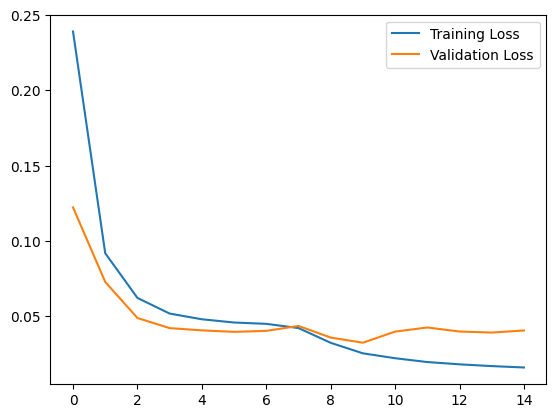

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
history2 = model5.fit(train_dataset, epochs=20, batch_size= 128,validation_data=val_dataset,callbacks=[lr_callback, early_stopping])

Epoch 1/20
16905/16905 [==============================] - 378s 22ms/step - loss: 0.0232 - tp: 633021.0000 - fp: 192473.0000 - tn: 1296311.0000 - fn: 41942.0000 - accuracy: 0.8917 - precision: 0.7668 - recall: 0.9379 - auc: 0.9726 - prc: 0.9515 - val_loss: 0.0361 - val_tp: 162177.0000 - val_fp: 112265.0000 - val_tn: 424764.0000 - val_fn: 21978.0000 - val_accuracy: 0.8139 - val_precision: 0.5909 - val_recall: 0.8807 - val_auc: 0.9265 - val_prc: 0.8817 - lr: 4.4933e-06
Epoch 2/20
16905/16905 [==============================] - 390s 23ms/step - loss: 0.0209 - tp: 638734.0000 - fp: 168858.0000 - tn: 1319926.0000 - fn: 36229.0000 - accuracy: 0.9052 - precision: 0.7909 - recall: 0.9463 - auc: 0.9787 - prc: 0.9616 - val_loss: 0.0343 - val_tp: 163603.0000 - val_fp: 99393.0000 - val_tn: 437636.0000 - val_fn: 20552.0000 - val_accuracy: 0.8337 - val_precision: 0.6221 - val_recall: 0.8884 - val_auc: 0.9391 - val_prc: 0.8949 - lr: 4.4933e-06
Epoch 3/20
16905/16905 [==============================] - 3

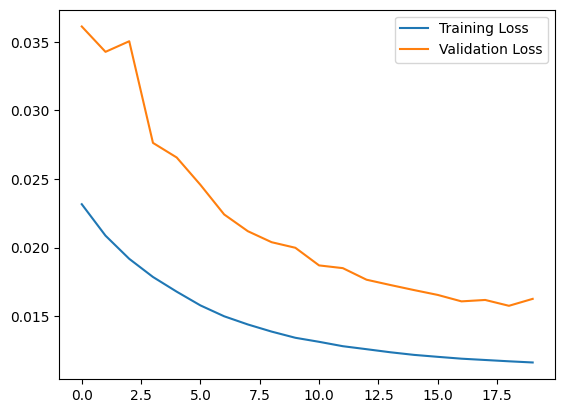

In [ ]:
plt.plot(history2.history["loss"], label="Training Loss")
plt.plot(history2.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
def lr_scheduler(epoch, lr):
    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
test_dataset = create_tf_dataset(test_data,test_labels,time_steps=100,batch_size=128)

In [ ]:
import tensorflow as tf

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/90prec72recall88acc.keras')

# Now you can use the loaded model for predictions or any other tasks


In [ ]:
preds = loaded_model.predict(test_dataset)

5635/5635 [==============================] - 30s 5ms/step


In [ ]:
def create_sequences_test(values, labels, time_steps=10):
    output_values = []
    output_labels = []
    for i in range(len(values) - time_steps + 1):
        output_values.append(values[i : (i + time_steps)])
        output_labels.append(labels[i + time_steps - 1])  # Assuming labels indicate the anomaly at the last timestep of each sequence
    return np.stack(output_values), np.array(output_labels)

In [ ]:
x_test, test_labels1=create_sequences(test_labels,time_steps=100)

In [ ]:
preds = loaded_model.predict(x_test)

22537/22537 [==============================] - 77s 3ms/step


In [ ]:
preds.shape

(721184, 1)

In [ ]:
preds_reshaped = preds.flatten()

In [ ]:
preds_reshaped.shape

(721184,)

In [ ]:
preds_re= tf.reshape(preds, [-1]).numpy()

In [ ]:
preds_re.shape

(721184,)

In [ ]:
test_labels1.shape

(721184,)

In [ ]:
#test_dataset2 = create_tf_dataset(test_data,None,time_steps=100,batch_size=128)
test_labels2 = create_sequences(test_labels,time_steps=100)

In [ ]:
test_labels2.shape

(721184, 100)

In [ ]:
preds_flat = preds.flatten()

In [ ]:
preds_flat.shape

(721184,)

In [ ]:
y_flat = tf.reshape(y_true, [-1]).numpy()

In [ ]:
y_flat.shape

(72118400,)

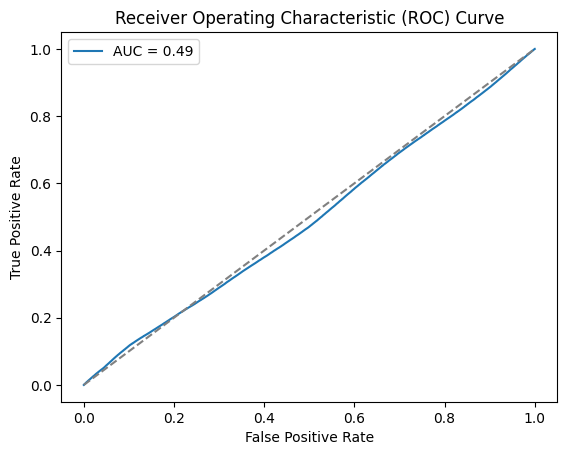

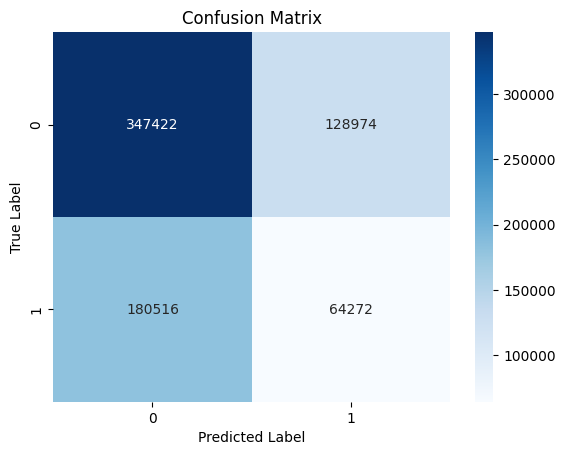

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
y_true = np.array(test_labels2)  # Convert test labels to numpy array if not already

# Step 3: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels1, preds_reshaped)
auc_score = roc_auc_score(test_labels1, preds_reshaped)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Step 4: Plot Confusion Matrix
cm = confusion_matrix(test_labels1, preds_reshaped.round())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
evaluation_results = loaded_model.evaluate(test_dataset)

# Display the evaluation results
for metric_name, metric_value in zip(loaded_model.metrics_names, evaluation_results):
    print(metric_name, ':', metric_value)

5635/5635 [==============================] - 42s 7ms/step - loss: 0.0887 - tp: 174711.0000 - fp: 18535.0000 - tn: 457884.0000 - fn: 70054.0000 - accuracy: 0.8772 - precision: 0.9041 - recall: 0.7138 - auc: 0.9322 - prc: 0.9054
loss : 0.08868059515953064
tp : 174711.0
fp : 18535.0
tn : 457884.0
fn : 70054.0
accuracy : 0.8771617412567139
precision : 0.9040859937667847
recall : 0.713790774345398
auc : 0.9322291016578674
prc : 0.9054117202758789


In [ ]:
evaluation_results = loaded_model.evaluate(test_dataset)

# Display the evaluation results
for metric_name, metric_value in zip(model5.metrics_names, evaluation_results):
    print(metric_name, ':', metric_value)

In [ ]:
evaluation_results_dict = {}

for metric_name, metric_value in zip(model5.metrics_names, evaluation_results):
    print(metric_name, ':', metric_value)
    evaluation_results_dict[metric_name] = metric_value

# Now you have the metric names and values stored in evaluation_results_dict
print(evaluation_results_dict)

loss : 0.08868059515953064
tp : 174711.0
fp : 18535.0
tn : 457884.0
fn : 70054.0
accuracy : 0.8771617412567139
precision : 0.9040859937667847
recall : 0.713790774345398
auc : 0.9322291016578674
prc : 0.9054117202758789
{'loss': 0.08868059515953064, 'tp': 174711.0, 'fp': 18535.0, 'tn': 457884.0, 'fn': 70054.0, 'accuracy': 0.8771617412567139, 'precision': 0.9040859937667847, 'recall': 0.713790774345398, 'auc': 0.9322291016578674, 'prc': 0.9054117202758789}


In [ ]:
model5.save('/content/drive/MyDrive/90prec72recall88acc.keras')

In [ ]:
import tensorflow_datasets as tfds


In [ ]:
X_test = tfds.load(test_dataset, split='test_data[:100%]')

TypeError: expected string or bytes-like object

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, f1_score
import matplotlib.pyplot as plt

# Assuming test_dataset contains both features and labels together

# Convert the dataset to a NumPy array
test_data = np.array(list(test_dataset.take(-1).as_numpy_iterator()))

# Extract features and labels
X_test = test_data[:, 0]  # Assuming features are in the first column
y_test = test_data[:, 1]  # Assuming labels are in the second column

# Predict probabilities for the positive class
y_probs = model5.predict(X_test)

# Assuming the model predicts probabilities rather than hard labels
# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred = (y_probs > 0.5).astype(int)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PRC Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Display confusion matrix
print("Confusion Matrix:")
print(conf_mat)

# Display F1 score
print("F1 Score:", f1)



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5635, 2) + inhomogeneous part.